<a href="https://colab.research.google.com/github/adammoss/bnn_hmc/blob/main/results/Mirabest_MCD_lenet_64_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import shutil
import subprocess
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
!nvidia-smi

Tue Aug 23 18:57:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install astro-datasets --upgrade
!pip install tensorflow_datasets --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for astro-datasets: filename=astro_datasets-0.0.10-py3-none-any.whl size=15992 sha256=762be962c0357e0d1fb61742ad9abc39cda8678fe3c4ea675b065e58a7f5799e
  Stored in directory: /root/.cache/pip/wheels/33/b2/9d/97c264f6addbd178fe1c8ff119617e1515cb8c0d0f220605cf
Successfully built astro-datasets
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
shutil.rmtree('bnn_hmc', ignore_errors=True)

In [5]:
!git clone https://github.com/adammoss/bnn_hmc

Cloning into 'bnn_hmc'...
remote: Enumerating objects: 499, done.
remote: Counting objects: 100% (211/211), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 499 (delta 149), reused 93 (delta 58), pack-reused 288
Receiving objects: 100% (499/499), 971.99 KiB | 3.48 MiB/s, done.
Resolving deltas: 100% (343/343), done.


In [6]:
!cd bnn_hmc && git checkout dropout_wip

Branch 'dropout_wip' set up to track remote branch 'dropout_wip' from 'origin'.
Switched to a new branch 'dropout_wip'


In [7]:
# https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install --upgrade https://storage.googleapis.com/jax-releases/cuda111/jaxlib-0.1.65+cuda111-cp37-none-manylinux2010_x86_64.whl
!pip install jax==0.2.12
!pip install dm-haiku==0.0.5.dev0 optax==0.0.6 chex==0.0.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 189.4 MB 17 kB/s 
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.14+cuda11.cudnn805
    Uninstalling jaxlib-0.3.14+cuda11.cudnn805:
      Successfully uninstalled jaxlib-0.3.14+cuda11.cudnn805
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 590 kB 13.5 MB/s 
  Created wheel for jax: filename=jax-0.2.12-py3-none-any.whl size=682487 sha256=c13fae0c7c70f5f44e764796f340c210c7b78c77885c03bf3b38d6a4c1c3fb4d
  Stored in directory: /root/.cache/pip/wheels/f6/4d/e5/73eec5070b77f25664c67bd793d4eb97f41bbf9be7afafd15e
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.14
    Uninstalling jax-0.3.14:
      Successfully uninstalled jax-0.3.14
Looking in indexes: https://pypi.org/simple, https://us-python.p

In [30]:
for i, root in enumerate(glob.glob('/content/runs/*/')):
  shutil.rmtree(root, ignore_errors=True)

In [31]:
!python3 bnn_hmc/scripts/run_sgd.py --seed=0 --weight_decay=10 --dir=runs/sgd/mirabestc/ \
--dataset_name=mirabest/confident --model_name=lenet_dropout --init_step_size=3e-7 --num_epochs=200 --eval_freq=5 \
--batch_size=53 --save_freq=5 --optimizer=SGD --train_split=train[:80%] --test_split=train[80%:] --patience 10 --dropout_rate 0.1 --image_size=64

JAX sees the following devices: [GpuDevice(id=0, process_index=0)]
TF sees the following devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Starting from random initialization with provided seed
/content/bnn_hmc/bnn_hmc/utils/script_utils.py:153: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predict_fn(net_apply, params, net_state, test_set, key))
/content/bnn_hmc/bnn_hmc/utils/script_utils.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predict_fn(net_apply, params, net_state, train_set, key))
---  --------  ----------

In [32]:
!python3 bnn_hmc/scripts/run_sgd.py --seed=0 --weight_decay=10 --dir=runs/sgd/mirabestc/ \
--dataset_name=mirabest/confident --model_name=lenet_dropout --init_step_size=3e-7 --num_epochs=200 --eval_freq=5 \
--batch_size=53 --save_freq=5 --optimizer=SGD --eval_split=test --repeats 10 --dropout_rate 0.1 --image_size=64

JAX sees the following devices: [GpuDevice(id=0, process_index=0)]
TF sees the following devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Continuing the run from the last saved checkpoint
bnn_hmc/scripts/run_sgd.py:188: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predict_fn(net_apply, params, net_state, test_set, key))
{'accuracy': DeviceArray(0.7980769, dtype=float32), 'nll': 0.42368758, 'ece': DeviceArray(0.12928662, dtype=float32)}
{'accuracy': DeviceArray(0.82692313, dtype=float32), 'nll': 0.40749693, 'ece': DeviceArray(0.10266504, dtype=float32)}
{'accuracy': DeviceArray(0.7788462, dtype=float32), 'nll': 0.4359023, 'ece': DeviceArray(0.11005834, dtype=float32)}
{'accuracy': DeviceArray(0.78846157, dtype=float32), 'nll': 0.43548253, 'e

In [33]:
softmax = []
for i, root in enumerate(glob.glob('/content/runs/sgd/mirabestc/*/predictions*npy')):
  data = np.load(root.replace('predictions', 'test_set')) 
  prediction = np.load(root)
  metrics = np.load(root.replace('predictions', 'metrics'), allow_pickle=True)
  print(metrics)
  softmax.append(np.squeeze(prediction))
softmax = np.array(softmax)

{'accuracy': array(0.78846157, dtype=float32), 'nll': 0.43548253, 'ece': array(0.09992589, dtype=float32)}
{'accuracy': array(0.82692313, dtype=float32), 'nll': 0.40749693, 'ece': array(0.10266504, dtype=float32)}
{'accuracy': array(0.78846157, dtype=float32), 'nll': 0.4168779, 'ece': array(0.08627478, dtype=float32)}
{'accuracy': array(0.7788462, dtype=float32), 'nll': 0.47164187, 'ece': array(0.13677299, dtype=float32)}
{'accuracy': array(0.7788462, dtype=float32), 'nll': 0.4359023, 'ece': array(0.11005834, dtype=float32)}
{'accuracy': array(0.7596154, dtype=float32), 'nll': 0.43346235, 'ece': array(0.07265346, dtype=float32)}
{'accuracy': array(0.82692313, dtype=float32), 'nll': 0.40050396, 'ece': array(0.07189962, dtype=float32)}
{'accuracy': array(0.78846157, dtype=float32), 'nll': 0.42939276, 'ece': array(0.09764922, dtype=float32)}
{'accuracy': array(0.7980769, dtype=float32), 'nll': 0.39923245, 'ece': array(0.10101091, dtype=float32)}
{'accuracy': array(0.7980769, dtype=float32

In [34]:
mean_softmax = np.mean(softmax, axis=0)
ensemble_accuracy = np.mean(np.argmax(mean_softmax, axis=-1) == data)
print('Ensemble accuracy', ensemble_accuracy)

Ensemble accuracy 0.8173076923076923


In [35]:
def uncertainty(softmax):
  # Per example softmax with shape(num_examples, num_classes)
  predictive_entropy = 0
  single_pass_entropy = 0
  for i in range(softmax.shape[1]):
    # Sum over classes
    predictive_entropy += -np.mean(softmax[:,i])*np.log(np.mean(softmax[:,i]))
    single_pass_entropy += -softmax[:,i]*np.log(softmax[:,i])
  single_pass_entropy = np.mean(single_pass_entropy)
  mutual_info = predictive_entropy - single_pass_entropy
  return predictive_entropy, single_pass_entropy, mutual_info

In [36]:
predictive_entropies = [] 
single_pass_entropies = []
mutual_infos = []
for i in range(softmax.shape[1]):
  predictive_entropy, single_pass_entropy, mutual_info = uncertainty(softmax[:,i,:])
  predictive_entropies.append(predictive_entropy)
  single_pass_entropies.append(single_pass_entropy)
  mutual_infos.append(mutual_info)
print('Predictive entropy:', np.mean(predictive_entropies), np.std(predictive_entropies))
print('Single pass entropy:', np.mean(single_pass_entropies), np.std(single_pass_entropies))
print('Mutual info:', np.mean(mutual_infos), np.std(mutual_infos))

Predictive entropy: 0.4766870346267332 0.18460015952918946
Single pass entropy: 0.41631457 0.16598146
Mutual info: 0.06037243846423315 0.04724010846464461


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


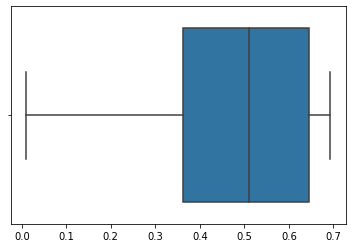

In [37]:
sns.boxplot(predictive_entropies)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


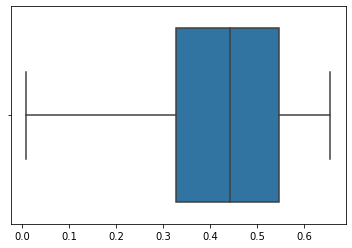

In [38]:
sns.boxplot(single_pass_entropies)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


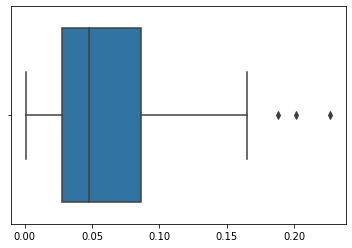

In [39]:
sns.boxplot(mutual_infos)
plt.show()